# r5r: Access to opportunities

```{admonition} Credits:

This tutorial is a direct copy from [r5r -documentation](https://ipeagit.github.io/r5r/articles/calculating_accessibility.html) made by r5r contributors.
```

## Getting started

### Run these codes in Binder

Before you can run this Notebook, and/or do any programming, you need to launch the Binder instance. You can find buttons for activating the python environment at the top-right of this page which look like this:

![Launch Binder](../img/launch_binder.png)

### Working with Jupyter Notebooks

Jupyter Notebooks are documents that can be used and run inside the JupyterLab programming environment containing the computer code and rich text elements (such as text, figures, tables and links). 

**A couple of hints**:

- You can **execute a cell** by clicking a given cell that you want to run and pressing <kbd>Shift</kbd> + <kbd>Enter</kbd> (or by clicking the "Play" button on top)
- You can **change the cell-type** between `Markdown` (for writing text) and `Code` (for writing/executing code) from the dropdown menu above. 

See **further details and help for** [**using Notebooks and JupyterLab from here**](https://pythongis.org/part1/chapter-01/nb/04-using-jupyterlab.html). 


## 1. Introduction 

Accessibility indicators measure the ease with which opportunities, such as jobs,
can be reached by a traveler from a particular location [@levinson2020manual]. One
of the simplest forms of accessibility metrics is the cumulative-opportunities, 
which counts all of the opportunities accessible from each location in less than a 
cutoff time. Using a travel time matrix and information on the number of opportunities available at each location, we can calculate and map accessibility. This vignette shows how to do that in R using the [`r5r` package](https://ipeagit.github.io/r5r/index.html).

In this reproducible example, we will be using a sample data set for the city of 
Porto Alegre (Brazil) included in `r5r`. We can compute accessibility in 5 quick 
steps:

1. Increase Java memory and load libraries
2. Build routable transport network
3. Calculate Accessibility
4. Map Accessibility



## 2. Build routable transport network with `setup_r5()`

### Increase Java memory and load libraries

Before we start, we need to increase the memory available to Java and load the 
packages used in this vignette

In [3]:
options(java.parameters = "-Xmx2G")

library(r5r)
library(sf)
library(data.table)
library(ggplot2)
library(interp)
library(dplyr)

To build a routable transport network with r5r and load it into memory, the user 
needs to call `setup_r5` with the path to the directory where OpenStreetMap and 
GTFS data are stored.

In [5]:
data_path <- system.file("extdata/poa", package = "r5r")

r5r_core <- setup_r5(data_path)

Using cached R5 version from /home/hentenka/.conda/envs/mamba/envs/r5/lib/R/library/r5r/jar/r5-v6.7-all.jar


Using cached network.dat from /home/hentenka/.conda/envs/mamba/envs/r5/lib/R/library/r5r/extdata/poa/network.dat



## 3. Calculate Accessibility

In this example, we will be calculating the number of schools and public healthcare facilities accessible by public transport within a travel time of up to 20 minutes. The sample data provided contains information on the spatial distribution of schools in Porto Alegre in the `points$schools` column, and healthcare facilities in the `points$healthcare` column. 

With the code below we compute the number of schools and healthcare accessible considering median of multiple travel time estimates departing every minute over a 60-minute time window, between 2pm and 3pm. The `accessibility()` function can calculate access to multiple opportunities in a single call, which is much more efficient and convenient than producing a travel time matrix of the study area and manually computing accessibility.


In [6]:
# read all points in the city
points <- fread(file.path(data_path, "poa_hexgrid.csv"))

# routing inputs
mode <- c("WALK", "TRANSIT")
max_walk_time <- 30 # in minutes
travel_time_cutoff <- 21 # in minutes
departure_datetime <- as.POSIXct("13-05-2019 14:00:00",
                                 format = "%d-%m-%Y %H:%M:%S")

time_window <- 60 # in minutes
percentiles <- 50

# calculate travel time matrix
access <- accessibility(r5r_core,
                        origins = points,
                        destinations = points,
                        mode = mode,
                        opportunities_colnames = c("schools", "healthcare"),
                        decay_function = "step",
                        cutoffs = travel_time_cutoff,
                        departure_datetime = departure_datetime,
                        max_walk_time = max_walk_time,
                        time_window = time_window,
                        percentiles = percentiles,
                        progress = FALSE)


head(access)

id,opportunity,percentile,cutoff,accessibility
<chr>,<chr>,<int>,<int>,<dbl>
89a901291abffff,schools,50,21,3
89a901291abffff,healthcare,50,21,6
89a9012a3cfffff,schools,50,21,0
89a9012a3cfffff,healthcare,50,21,0
89a901295b7ffff,schools,50,21,6
89a901295b7ffff,healthcare,50,21,4


## 4. Map Accessibility

The final step is mapping the accessibility results calculated earlier. The code
below demonstrates how to do that, with some extra steps to produce a prettier map by doing a spatial interpolation of accessibility estimates.


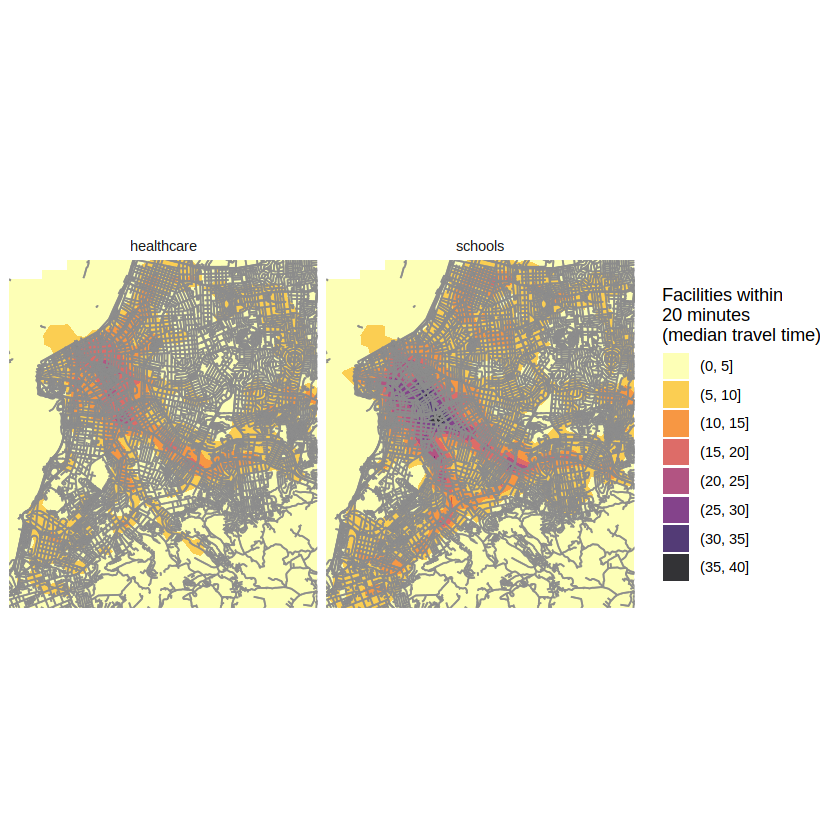

In [7]:
# interpolate estimates to get spatially smooth result
access_schools <- access %>% 
  filter(opportunity == "schools") %>%
  inner_join(points, by='id') %>%
  with(interp::interp(lon, lat, accessibility)) %>%
  with(cbind(acc=as.vector(z),  # Column-major order
             x=rep(x, times=length(y)),
             y=rep(y, each=length(x)))) %>% as.data.frame() %>% na.omit() %>%
  mutate(opportunity = "schools")

access_health <- access %>% 
  filter(opportunity == "healthcare") %>%
  inner_join(points, by='id') %>%
  with(interp::interp(lon, lat, accessibility)) %>%
  with(cbind(acc=as.vector(z),  # Column-major order
             x=rep(x, times=length(y)),
             y=rep(y, each=length(x)))) %>% as.data.frame() %>% na.omit() %>%
  mutate(opportunity = "healthcare")

access.interp <- rbind(access_schools, access_health)

# find results' bounding box to crop the map
bb_x <- c(min(access.interp$x), max(access.interp$x))
bb_y <- c(min(access.interp$y), max(access.interp$y))

# extract OSM network, to plot over map
street_net <- street_network_to_sf(r5r_core)

# plot
ggplot(na.omit(access.interp)) +
  geom_contour_filled(aes(x=x, y=y, z=acc), alpha=.8) +
  geom_sf(data = street_net$edges, color = "gray55", size=0.1, alpha = 0.9) +
  scale_fill_viridis_d(direction = -1, option = 'B') +
  scale_x_continuous(expand=c(0,0)) +
  scale_y_continuous(expand=c(0,0)) +
  coord_sf(xlim = bb_x, ylim = bb_y, datum = NA) + 
  labs(fill = "Facilities within\n20 minutes\n(median travel time)") +
  theme_minimal() +
  theme(axis.title = element_blank()) +
  facet_wrap(~opportunity)

If you have any suggestions or want to report an error, please visit [the package GitHub page](https://github.com/ipeaGIT/r5r).